# fairness_toolkit Tutorial
## Assessing Intersectional Fairness in a Health Classification Model

This notebook demonstrates how to use the fairness_toolkit Python package to:

1. Load a medical dataset

2. Train a simple classification model

3. Create intersectional groups (e.g., sex and age group)

4. Compute Differential Fairness (ε)

5. Visualise fairness across subgroups

The purpose of this example is to show a typical health data science workflow where fairness matters. For example, predicting heart disease risk.

## 1. Install and import the toolkit

In [74]:
from fairness.groups import create_intersectional_groups
from fairness.differential_fairness import differential_fairness
from fairness.plots import plot_group_fairness

import pandas as pd
import numpy as np

## Load Data

In this example, we will use the UCI Heart Disease dataset, a well-known dataset in medical machine learning. Each row in the dataset represents a single patient, and each column describes a different clinical measurement or characteristic, such as:

- age
- sex
- resting blood pressure
- cholesterol level
- exercise-induced angina

The outcome we want to predict is contained in the target column:

- 0 : the patient does not have heart disease
- 1 : the patient does have heart disease

This is a binary classification problem, and it provides a realistic scenario in which fairness matters. In a healthcare setting, if a predictive model behaves differently for different groups of patients (for example, across sex or age), it could lead to unequal access to diagnosis, treatment, or follow-up investigations.

By loading this dataset into a DataFrame, we can:

- Explore its structure
- Prepare the protected attributes
- Train a machine-learning model
- Assess whether the model treats different demographic groups fairly

This makes it an suitable dataset for demonstrating how the fairness toolkit works.

In [75]:
df = pd.read_csv('fairness/data/heart.csv')

# convert sex M/F to 0/1 so sklearn can process it
df["Sex"] = df["Sex"].map({"M": 1, "F": 0})

# One-hot encode categorical variables, turning catagorical columsn into numeric dummy variables 
df = pd.get_dummies(df, drop_first=True)


df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0,True,False,False,True,False,False,False,True
1,49,0,160,180,0,156,1.0,1,False,True,False,True,False,False,True,False
2,37,1,130,283,0,98,0.0,0,True,False,False,False,True,False,False,True
3,48,0,138,214,0,108,1.5,1,False,False,False,True,False,True,True,False
4,54,1,150,195,0,122,0.0,0,False,True,False,True,False,False,False,True


## Prepare the dataset

Before we can analyse fairness, we need to ensure that our dataset includes the protected characteristics we want to study. In this example, we focus on:

* sex
* age

While sex is already provided in the dataset, age is a continuous numeric variable (e.g., 45, 62, 31). Continuous values are difficult to use directly in fairness analysis because:

* They produce far too many unique groups
* It becomes impossible to compare “age 45” vs “age 47” meaningfully
* Many groups would be too small to analyse reliably

To solve this, we convert age into a small number of age groups (or “bins”), such as:

* young
* middle
* old

This process helps create meaningful, interpretable intersectional groups. For example: “sex = female AND age = old”.

These categories allow us to check whether the model behaves differently for younger vs older patients, and whether this interacts with sex.

Creating age groups also helps:

* Reduce noise in the analysis
* Ensure each group has enough samples
* Make the final fairness results easier to explain to clinicians and decision-makers

So this step prepares the dataset for the intersectional fairness analysis by transforming raw numerical age into simple, interpretable categories that can be used to define subgroups.


In [76]:
df["age_group"] = pd.cut(
    df["Age"],
    bins=[0, 55, 120],
    labels=["young", "older"]
)

df[["Age", "age_group", "Sex"]].head()


,Age,age_group,Sex
0,40,young,1
1,49,young,0
2,37,young,1
3,48,young,0
4,54,young,1


## List Protected attributes to study:

In fairness and ethics work, the term protected characteristics refers to attributes of people that society (and law) recognises as needing protection from discrimination.

Examples typically include sex, age, race/ethnicity, disability, religion and sexual orientation.

These characteristics are considered "protected" because they are sensitive attributes about identity, and they have historically been targets of discrimination.

Unequal treatment based on them may be legally unacceptable, and biased outcomes affecting these groups can cause harm.

In [77]:
protected = ["Sex", "age_group"]


# Train a simple classification model

In this example, we train a Logistic Regression model — a widely used method in healthcare because it is simple, interpretable, and effective for binary outcomes.
Our goal is to predict whether a patient has heart disease based on clinical features.

However, it is important to note that the fairness toolkit does not depend on logistic regression. It works with predictions from any machine-learning model.

As long as you can provide:

- the true labels (y_true),
- the model predictions (y_pred), and
- the protected group labels,

the toolkit can compute fairness metrics.

The fairness analysis is model-agnostic. The classifier used here is simply an example to demonstrate how the toolkit fits into a typical health data science workflow.

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define inputs and output
X = df.drop(["HeartDisease", "age_group"], axis=1)
y = df["HeartDisease"]

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


/opt/miniconda3/envs/hds_code/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Create Intersectional Groups from Protected Characteristics

To assess fairness properly, we need to examine how a model behaves for different groups of people, especially groups defined by sensitive or protected characteristics such as sex or age.

Often, unfairness appears not in simple categories (e.g., “men vs women”), but in the intersections of characteristics — for example:

* older women
* younger men

Lookin at these intersecting groups can reveal patterns of discrimination that would otherwise remain hidden.

The `create_intersectional_groups()` function takes:

* the dataset
* a list of protected attributes (e.g., `["sex", "age_group"]`)

It then creates a combined label for each row that represents the person’s membership in these intersecting groups.

For example:

* `"sex=1|age_group=older"`
* `"sex=0|age_group=young"`

Each label uniquely identifies one intersectional subgroup.

These labels allow us to:

* calculate fairness metrics *per subgroup*
* compare how different groups are treated
* see whether the model’s performance is consistent
* identify where the worst disparities occur

The labels follow a simple, consistent and human readable format:

```
attribute1=value1 | attribute2=value2 | attribute3=value3 ...
```

this will produce labels like:

```
"sex=1|age_group=old"
```

The fairness toolkit depends on these group labels to calculate how the model treats each group differently.


In [79]:
groups, group_map, counts = create_intersectional_groups(
    df.loc[X_test.index],
    protected
)

counts


Sex=1|age_group=young    127
Sex=1|age_group=older    103
Sex=0|age_group=older     26
Sex=0|age_group=young     20
Name: count, dtype: int64

In [80]:
df_df = pd.DataFrame({"y_pred": y_pred, "group": groups})
group_counts = df_df.groupby("group")["y_pred"].count()
positive_counts = df_df.groupby("group")["y_pred"].sum()

probs = (positive_counts + 1e-6) / (group_counts + 2*1e-6)
print("probs =", probs)
print("type =", type(probs))
print("values =", probs.values)



probs = group
Sex=0|age_group=older    0.269231
Sex=0|age_group=young    0.200000
Sex=1|age_group=older    0.766990
Sex=1|age_group=young    0.511811
Name: y_pred, dtype: float64
type = <class 'pandas.core.series.Series'>
values = [0.26923079 0.20000003 0.76699029 0.51181102]


# Compute differential fairness

Differential Fairness measures how differently the model treats different intersectional groups.

Differential Fairness measures the worst-case difference in how the model treats different intersectional groups. A value of ε = 0 means all groups are treated the same. Larger values indicate more unfairness.

Taking exp(ε) gives a simple ratio telling us how many times more likely the most advantaged group is to receive a positive prediction compared to the least advantaged group. Lower values are better because they indicate more equal treatment across groups.

In [81]:
eps = differential_fairness(y_pred, groups)

print (round((np.exp(eps)),3)
)

5.5


If exp(eps) = 5.5, as in this example:

The most advantaged group is 5.5 times more likely to receive a positive prediction than the least advantaged group.
Smaller values are more fair.

A plain-English summary might be:

“In this model, the difference in treatment between the most advantaged and least advantaged intersectional groups is about 5.5-fold. This suggests the model has a high level of unfairness depending, on your threshold.”

## Visualise fairness by intersectional group

This plot helps identify which groups (e.g., older women, younger men) are treated differently.

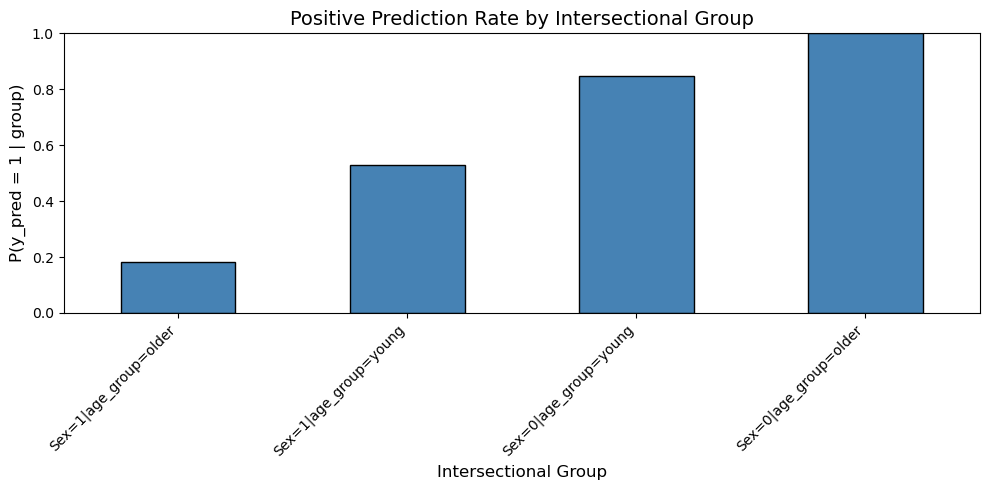

In [82]:
plot_group_fairness(y_pred, groups)


Summary

In this tutorial, we have:

1. Loaded a real medical dataset
2. Trained a simple logistic regression classifier
3. Defined protected attributes (sex and age group)
4. Created intersectional patient groups
5. Calculated Differential Fairness (ε)
6. Plotted group-by-group fairness outcomes

This workflow shows how a health data scientist can use fairness_toolkit to check whether a predictive model treats different patient groups fairly.